# Deep Convolutional GAN (DCGAN)

### Goal
In this notebook, you're going to create another GAN using the Celeb-A Faces  dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

### Learning Objectives
1.   Get hands-on experience making a widely used GAN: Deep Convolutional GAN (DCGAN).
2.   Train a powerful generative model.


<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-01_at_11.27.51_PM_IoGbo1i.png" height = 300 width = 600>

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Getting Started

#### DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!): 

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import numpy as np

torch.manual_seed(0) # Set for testing purposes, please do not change!

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." --> 
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">build_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

In [2]:
# build_gen_block 함수에서 START CODE, END CODE 사이의 코드를 채워 넣어주세요.
# Parameters 설명과 Steps을 참고하여 Generator block이 어떻게 생성되는지 확인해주세요.
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: Noise 벡터의 차원(scalar)
        im_chan: Output image의 채널 수(scalar)
              ( MNIST,Fashion MNIST : 1 / Cifar-10 : 3 )
        hidden_dim: hidden vector의 차원(scalar)
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.build_gen_block(z_dim, hidden_dim * 4),
            self.build_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.build_gen_block(hidden_dim * 2, hidden_dim),
            self.build_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def build_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Transposed convolution, Batch normalization, activation function을 이용하여,
        DCGAN의 생성자 블록과 일치하는 일련의 연산들을 반환하는 함수
        Parameters:
            input_channels: input feature의 차원(scalar)
            output_channels: output feature의 차원(scalar)
            kernel_size: convolution 필터 사이즈(scalar)
            stride: convolution 보폭(scalar)
            final_layer: boolean값으로, final layer일 경우 true, else false
        '''
    
        #     Steps(total : 10 points):
        #       1) 위에서 주어진 매개변수들을 사용하여 transposed convolution 수행
        #       2) final layer를 제외하고 batch norm 수행
        #       3) batch norm 이후 ReLU 활성화 함수 수행
        #       4) final layer의 경우, ReLU대신 Tanh 활성화 함수 수행

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE(5 points) ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE(5 points) ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        noise vector가 주어지면, width와 height가 1 그리고 channels값이 z_dim인 shape의 tensor를 반환하는 함수
        Parameters:
            noise shape : (n_samples, z_dim)
            output shape : (n_samples, z_dim, 1, 1)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Generator의 순전파 연산 함수
        noise 텐서를 입력으로 받아 생성된 이미지를 반환
        Parameters:
            noise: noise shape : (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    noise 벡터 생성 함수
    주어진 파라미터를 입력받아 정규 분포로부터 난수들로 채워진 형태의 tensor 생성
    Parameters:
        n_samples: 생성하는 샘플들의 수(scalar)
        z_dim: noise vector의 차원(scalar)
        device: cpu / gpu
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.
'''
Test your build_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.build_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.build_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.build_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.
# UNIT TESTS.
# SUCESS가 출력되지 않을시, Generator class를 다시 한번 확인해보세요.
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!") 

Success!


## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.
<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">build_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

In [5]:
# build_disc_block 함수에서 START CODE, END CODE 사이의 코드를 채워 넣어주세요.
# Parameters 설명과 Steps을 참고하여 Discriminator block이 어떻게 생성되는지 확인해주세요.
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: Output image의 채널 수(scalar)
              ( MNIST,Fashion MNIST : 1 / Cifar-10 : 3 )
    hidden_dim: hidden vector의 차원(scalar)
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.build_disc_block(im_chan, hidden_dim),
            self.build_disc_block(hidden_dim, hidden_dim * 2),
            self.build_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def build_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: input feature의 차원(scalar)
            output_channels: output feature의 차원(scalar)
            kernel_size: convolution 필터 사이즈(scalar)
            stride: convolution 보폭(scalar)
            final_layer: boolean값으로, final layer일 경우 true, else false
        '''
        #     Steps(total : 10 points):
        #       1) 위에서 주어진 매개변수들을 사용하여 convolution 수행
        #       2) final layer를 제외하고 batch norm 수행
        #       3) batch norm 이후 LeakyReLU 활성화 함수 수행. 이때 slope 0.2는 고정(Optional Hint 참고)
        #       4) 기존 DCGAN 실습과 달리 final layer에는 어떠한 activation을 적용하지 않음
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE(5 points) ####
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE(5 points) ####
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Discriminator의 순전파 연산 함수
        image 텐서를 입력으로 받아 real/fake를 나타내는 1D tensor를 반환
        Parameters:
            image: flattened 된 image tensor
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.
'''
Test your build_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.build_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.build_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [7]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.
# UNIT TESTS.
# SUCESS가 출력되지 않을시, Discriminator class를 다시 한번 확인해보세요.
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Dataset



In [8]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.
def show_tensor_images(image_tensor, title, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.title(title)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [9]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.

# Binary Cross Entropy Loss
bce_loss = nn.BCEWithLogitsLoss()
# Mean Squared Error Loss
mse_loss = nn.MSELoss()

z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    dset.MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Then, you can initialize your generator, discriminator, and optimizers.

In [10]:
# DO NOT EDIT THIS CELL.
# JUST RUN IT.

# BCE Loss를 이용하는 모델(generator, discriminator), optimizers 선언
gen_with_bce = Generator(z_dim).to(device)
gen_opt_with_bce = torch.optim.Adam(gen_with_bce.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_with_bce = Discriminator().to(device) 
disc_opt_with_bce = torch.optim.Adam(disc_with_bce.parameters(), lr=lr, betas=(beta_1, beta_2))

# MSE Loss를 이용하는 모델(generator, discriminator), optimizers 선언
gen_with_mse = Generator(z_dim).to(device)
gen_opt_with_mse = torch.optim.Adam(gen_with_mse.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_with_mse = Discriminator().to(device) 
disc_opt_with_mse = torch.optim.Adam(disc_with_mse.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# BCE Loss를 이용하는 모델(generator, discriminator)의 가중치 초기화 적용
gen_with_bce = gen_with_bce.apply(weights_init)
disc_with_bce = disc_with_bce.apply(weights_init)

# MSE Loss를 이용하는 모델(generator, discriminator)의 가중치 초기화 적용
gen_with_mse = gen_with_mse.apply(weights_init)
disc_with_mse = disc_with_mse.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

다음 Cell은 Binary Cross Entropy Loss와 Mean Squared Error를 이용하여 두쌍의 generator, discrimator를 학습합니다.
1. 학습 과정을 확인하며 각 과정마다 의미하는 내용을 간단한 주석으로 적어주세요.(10 points)
##### 예)
```python
        # noise vector를 입력받아 generator는 fake 이미지를 생성
        fake_with_bce = gen_with_bce(fake_noise)
        fake_with_mse = gen_with_mse(fake_noise)
```
2. 두개의 Loss 함수(BCE,MSE)에 대해서 출력되는 결과를 분석하여, 각 Loss가 학습에 어떤 차이가 있는지 확인해보고, 과제 보고서에 비교결과를 적으시오. 필요하면 학습과정의 일부를 캡쳐하여 그림파일로 추가해도 됩니다.(10 points)
* 필요시 Loss 그래프 시각화하여 첨부 가능
* [참고 논문] [LSGAN] https://arxiv.org/pdf/1611.04076.pdf

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss(BCE): 0.8168871679902076, Discriminator loss(BCE): 0.5504005351066584
Step 500: Generator loss(MSE): 0.6601924098134039, Discriminator loss(MSE): 0.13139155081100767


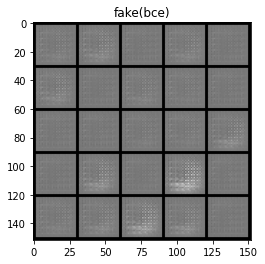

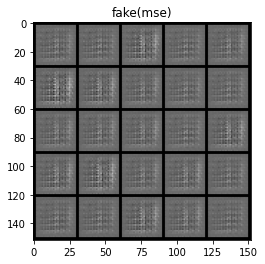

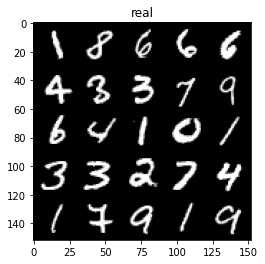

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss(BCE): 1.9306123037338254, Discriminator loss(BCE): 0.19419582808017716
Step 1000: Generator loss(MSE): 0.9599121556878096, Discriminator loss(MSE): 0.03532417885400357


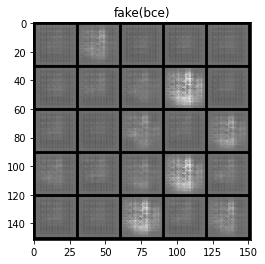

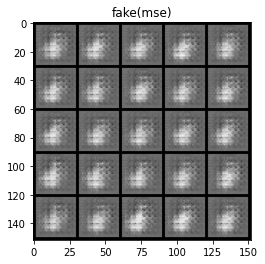

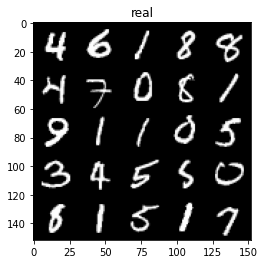

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss(BCE): 1.7891910132169728, Discriminator loss(BCE): 0.35108154083788423
Step 1500: Generator loss(MSE): 0.6179712056275454, Discriminator loss(MSE): 0.13238692544400704


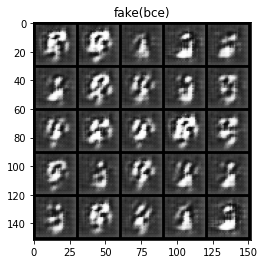

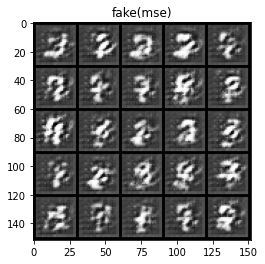

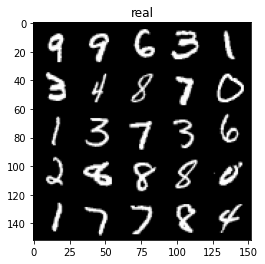

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss(BCE): 1.216505203038455, Discriminator loss(BCE): 0.5053288767933845
Step 2000: Generator loss(MSE): 0.42257924380712225, Discriminator loss(MSE): 0.18105171580612672


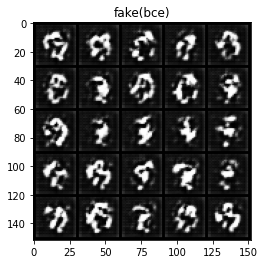

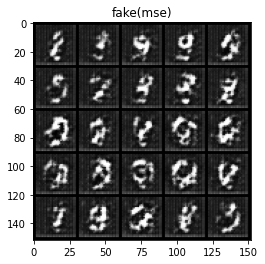

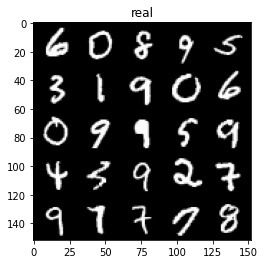

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss(BCE): 1.0091663909554485, Discriminator loss(BCE): 0.5505911747813228
Step 2500: Generator loss(MSE): 0.40028131251037086, Discriminator loss(MSE): 0.1854311724752189


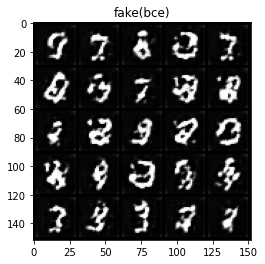

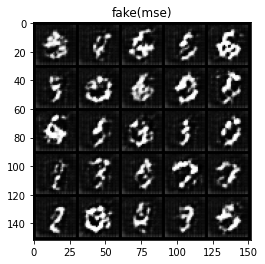

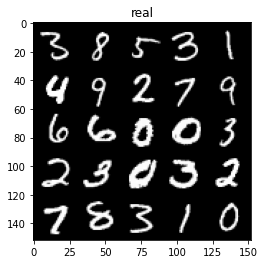

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss(BCE): 0.9302485904693598, Discriminator loss(BCE): 0.5816986465454109
Step 3000: Generator loss(MSE): 0.3719702832400797, Discriminator loss(MSE): 0.19505961760878557


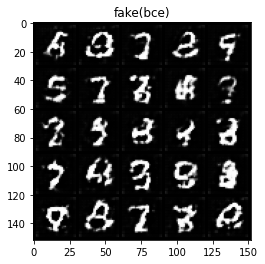

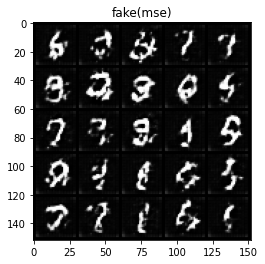

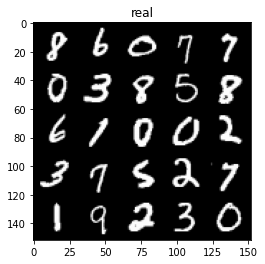

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss(BCE): 0.8504888406395908, Discriminator loss(BCE): 0.6167940353155136
Step 3500: Generator loss(MSE): 0.3493740057796239, Discriminator loss(MSE): 0.20706494930386524


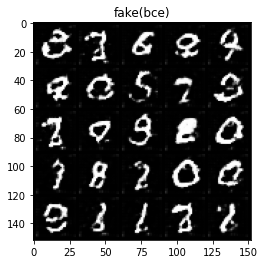

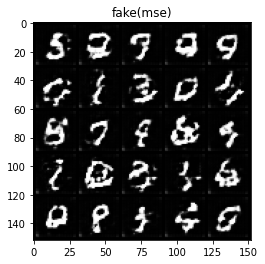

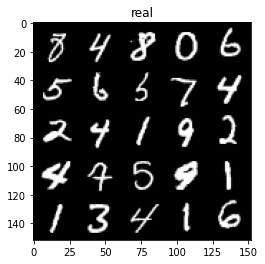

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss(BCE): 0.8252167143225668, Discriminator loss(BCE): 0.6377967555522926
Step 4000: Generator loss(MSE): 0.33129904499649976, Discriminator loss(MSE): 0.21435455951094612


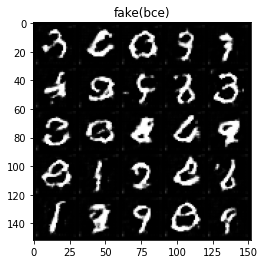

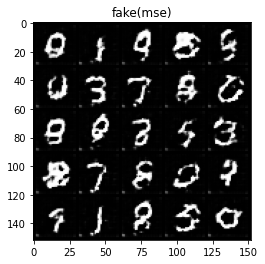

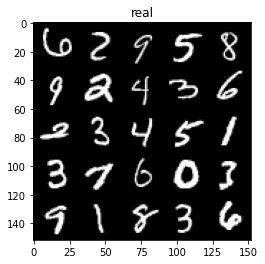

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss(BCE): 0.8114773896932601, Discriminator loss(BCE): 0.6529543828964236
Step 4500: Generator loss(MSE): 0.33559618350863474, Discriminator loss(MSE): 0.21828920283913622


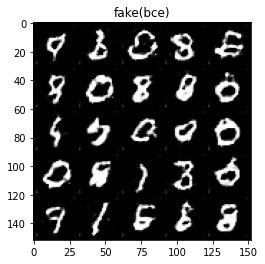

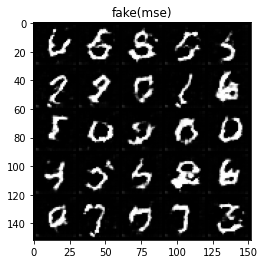

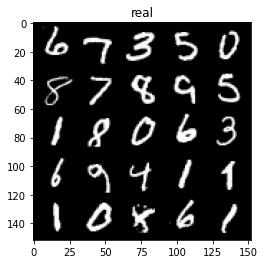

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss(BCE): 0.7912473602294924, Discriminator loss(BCE): 0.6599177970886229
Step 5000: Generator loss(MSE): 0.32769542875885965, Discriminator loss(MSE): 0.2223232419490816


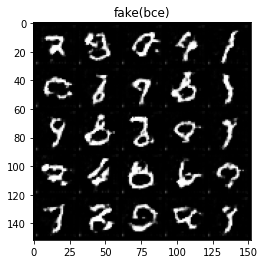

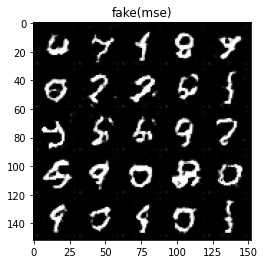

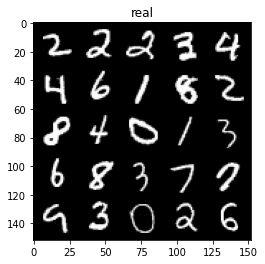

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss(BCE): 0.778347715258598, Discriminator loss(BCE): 0.6658855818510052
Step 5500: Generator loss(MSE): 0.31494390389323246, Discriminator loss(MSE): 0.22628077042102815


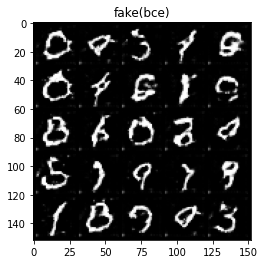

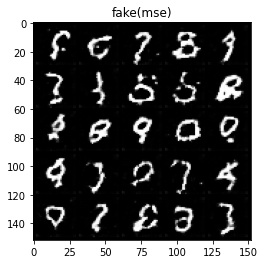

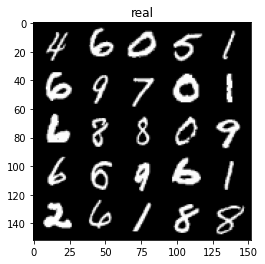

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss(BCE): 0.7659563813805577, Discriminator loss(BCE): 0.6752672934532166
Step 6000: Generator loss(MSE): 0.3069852466434238, Discriminator loss(MSE): 0.2338669819533824


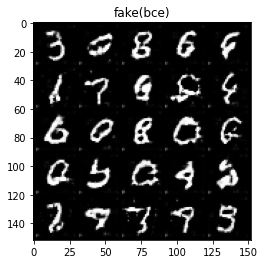

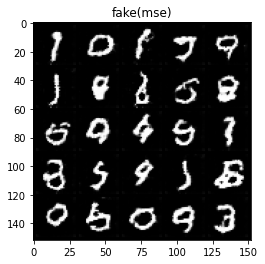

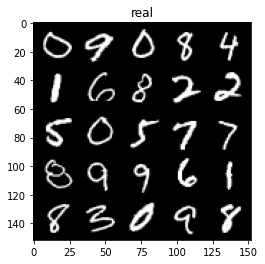

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss(BCE): 0.7571658412218104, Discriminator loss(BCE): 0.6786934621334079
Step 6500: Generator loss(MSE): 0.30143055978417377, Discriminator loss(MSE): 0.2355101382136343


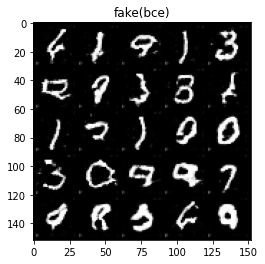

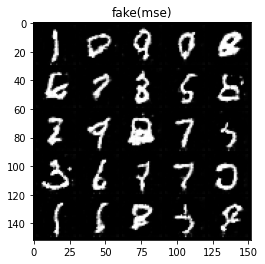

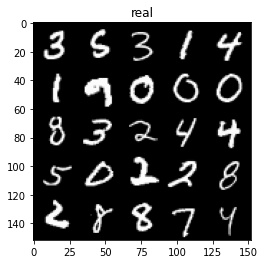

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss(BCE): 0.7554868039488792, Discriminator loss(BCE): 0.681433575987816
Step 7000: Generator loss(MSE): 0.292954965621233, Discriminator loss(MSE): 0.23832457825541478


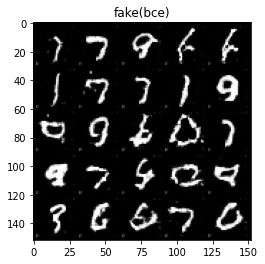

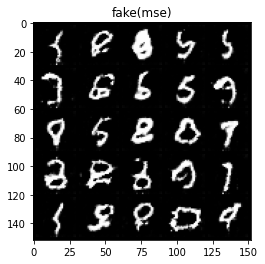

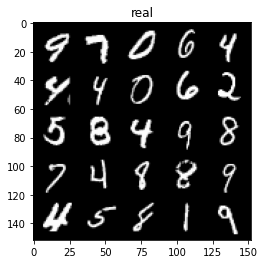

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss(BCE): 0.7456723637580869, Discriminator loss(BCE): 0.6846305320262908
Step 7500: Generator loss(MSE): 0.2886743633151056, Discriminator loss(MSE): 0.24056498110294333


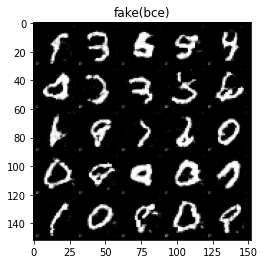

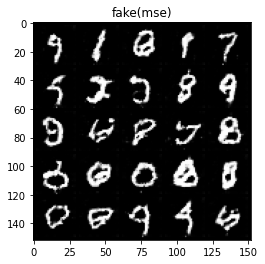

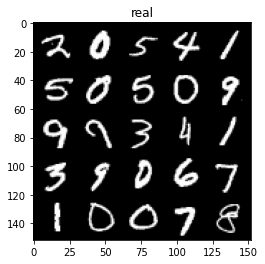

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss(BCE): 0.73820167094469, Discriminator loss(BCE): 0.6885147669315345
Step 8000: Generator loss(MSE): 0.28332132300734497, Discriminator loss(MSE): 0.24473596715927123


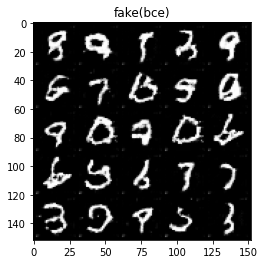

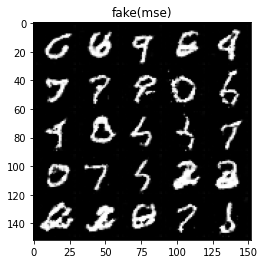

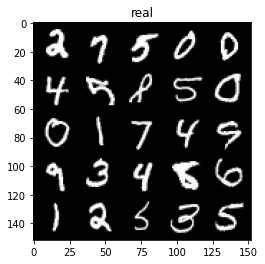

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss(BCE): 0.735697615325451, Discriminator loss(BCE): 0.6900729535818093
Step 8500: Generator loss(MSE): 0.2794373083412647, Discriminator loss(MSE): 0.24614205753803273


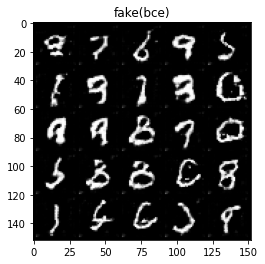

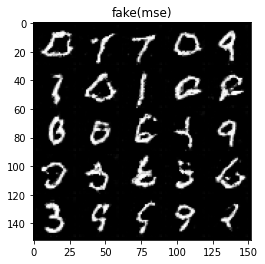

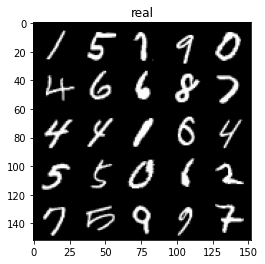

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss(BCE): 0.7264692875146861, Discriminator loss(BCE): 0.6908723360300065
Step 9000: Generator loss(MSE): 0.2720426652431487, Discriminator loss(MSE): 0.24813549694418913


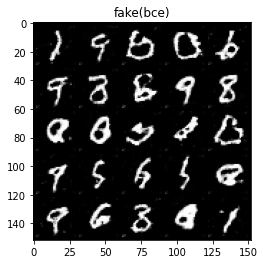

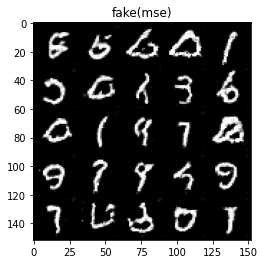

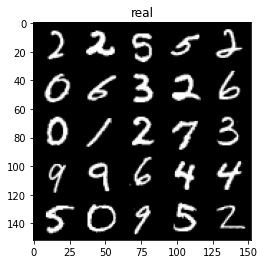

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss(BCE): 0.7265399953722953, Discriminator loss(BCE): 0.6929741370677954
Step 9500: Generator loss(MSE): 0.2723098410069941, Discriminator loss(MSE): 0.25018982490897157


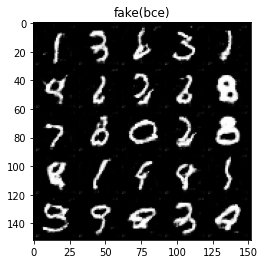

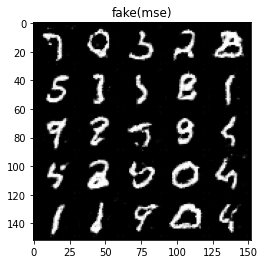

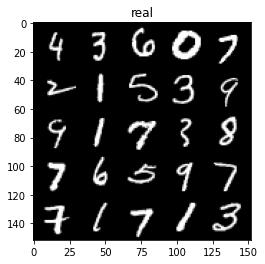

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss(BCE): 0.724900213479995, Discriminator loss(BCE): 0.6943879299163824
Step 10000: Generator loss(MSE): 0.27085506358742717, Discriminator loss(MSE): 0.24998844140768053


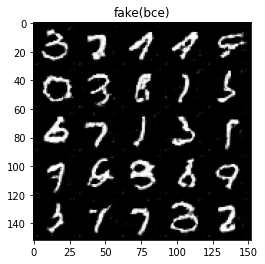

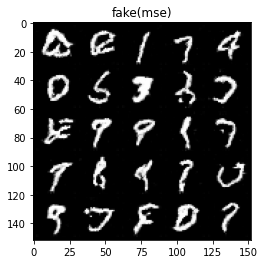

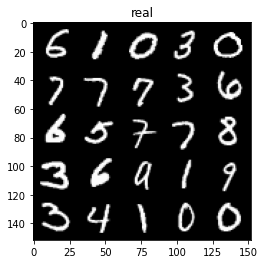

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss(BCE): 0.7224641698598855, Discriminator loss(BCE): 0.6942685433626179
Step 10500: Generator loss(MSE): 0.26821438120305496, Discriminator loss(MSE): 0.2501504789888859


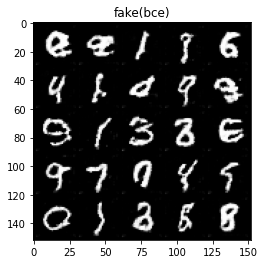

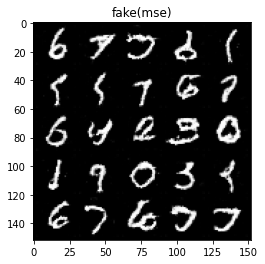

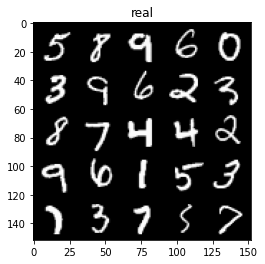

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss(BCE): 0.7161309800148007, Discriminator loss(BCE): 0.694225613713264
Step 11000: Generator loss(MSE): 0.2629836549162864, Discriminator loss(MSE): 0.25017562490701656


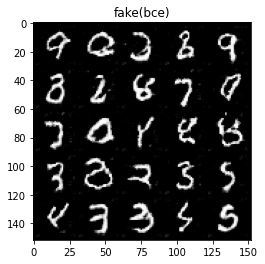

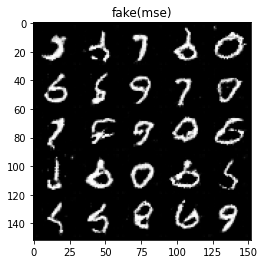

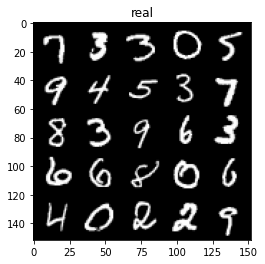

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss(BCE): 0.7159435397386555, Discriminator loss(BCE): 0.6965785256624224
Step 11500: Generator loss(MSE): 0.2652780803889036, Discriminator loss(MSE): 0.2511299794614317


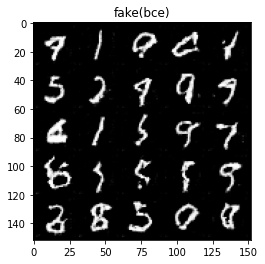

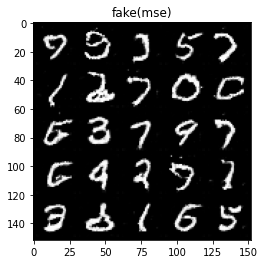

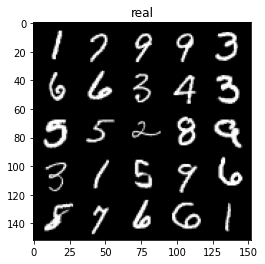

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss(BCE): 0.7166480125188828, Discriminator loss(BCE): 0.6954978609085086
Step 12000: Generator loss(MSE): 0.2619212884157898, Discriminator loss(MSE): 0.25217431867122647


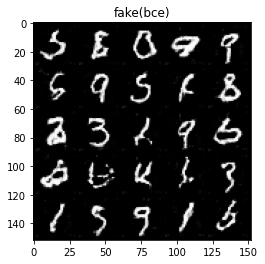

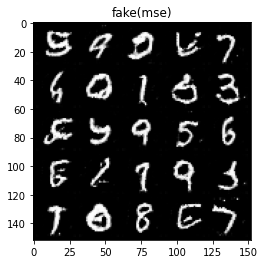

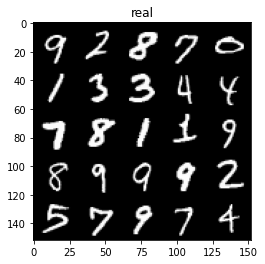

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss(BCE): 0.7131468923091889, Discriminator loss(BCE): 0.6957496446371086
Step 12500: Generator loss(MSE): 0.25992150896787614, Discriminator loss(MSE): 0.2516739356219769


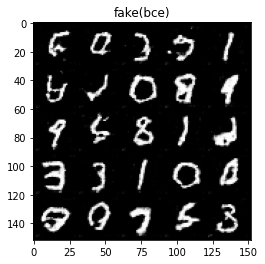

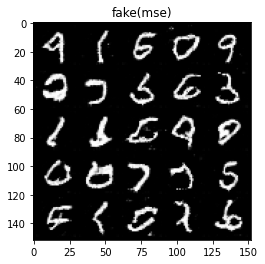

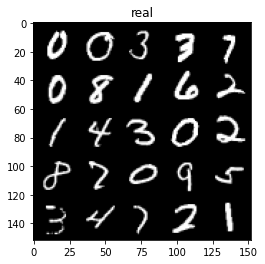

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss(BCE): 0.7138702180385589, Discriminator loss(BCE): 0.6968525941371919
Step 13000: Generator loss(MSE): 0.26105352994799624, Discriminator loss(MSE): 0.2520221200585365


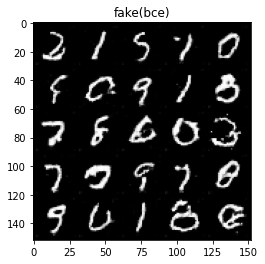

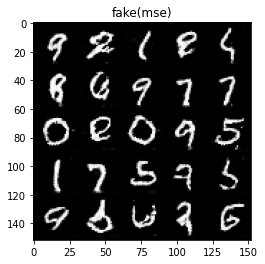

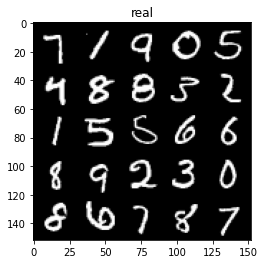

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss(BCE): 0.7107790244817722, Discriminator loss(BCE): 0.6969605300426472
Step 13500: Generator loss(MSE): 0.26113826611638064, Discriminator loss(MSE): 0.25190936988592155


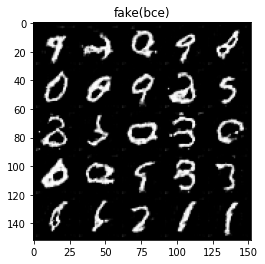

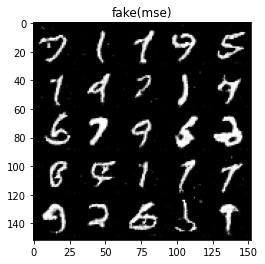

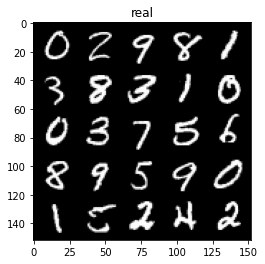

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss(BCE): 0.7080292776823036, Discriminator loss(BCE): 0.6973522449731828
Step 14000: Generator loss(MSE): 0.25995732203125926, Discriminator loss(MSE): 0.25161656129360177


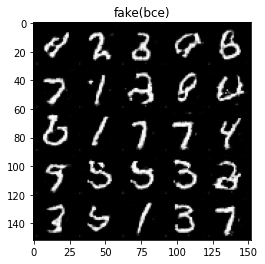

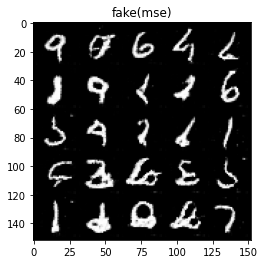

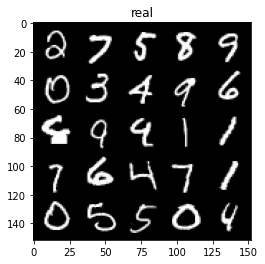

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss(BCE): 0.7071346958875657, Discriminator loss(BCE): 0.6978649609088893
Step 14500: Generator loss(MSE): 0.2593775741159917, Discriminator loss(MSE): 0.2513294822573664


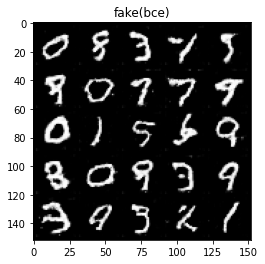

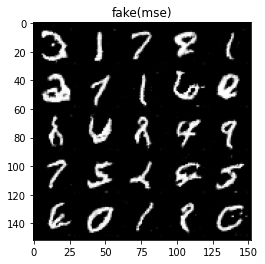

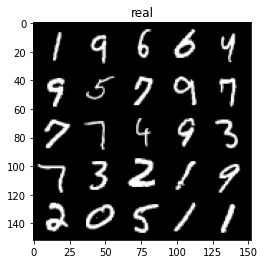

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss(BCE): 0.7052917726039877, Discriminator loss(BCE): 0.6976287875175475
Step 15000: Generator loss(MSE): 0.25772385041415713, Discriminator loss(MSE): 0.2514941529333593


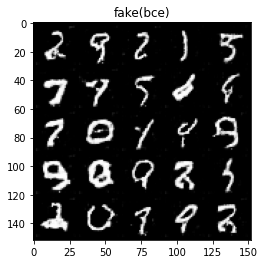

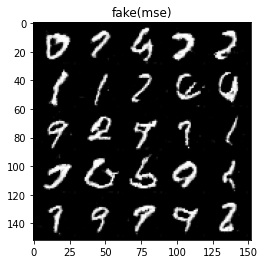

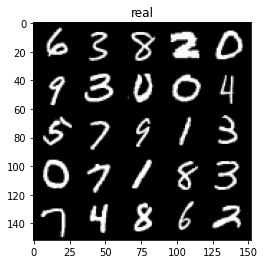

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss(BCE): 0.7018479408025738, Discriminator loss(BCE): 0.6973876368999481
Step 15500: Generator loss(MSE): 0.26014309786260126, Discriminator loss(MSE): 0.25195616033673296


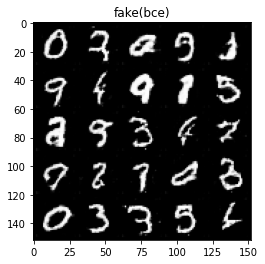

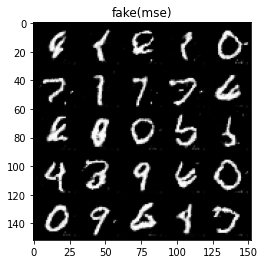

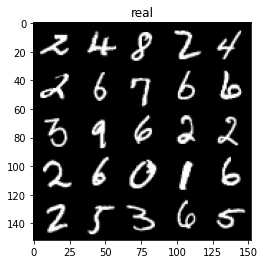

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss(BCE): 0.7056888415813446, Discriminator loss(BCE): 0.6975723767280574
Step 16000: Generator loss(MSE): 0.25506773722171805, Discriminator loss(MSE): 0.25243319445848483


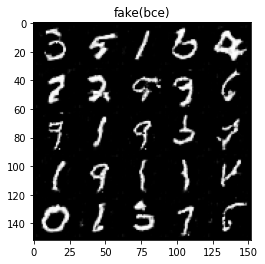

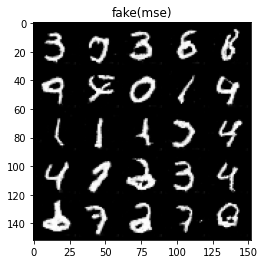

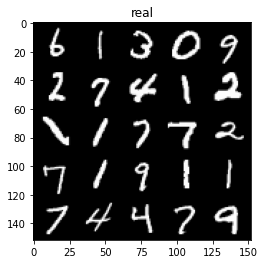

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss(BCE): 0.7021480584740643, Discriminator loss(BCE): 0.6973975565433501
Step 16500: Generator loss(MSE): 0.25744366753101344, Discriminator loss(MSE): 0.2515201857089998


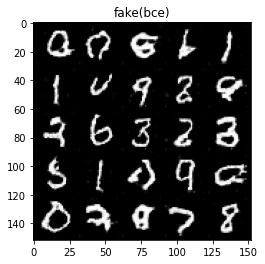

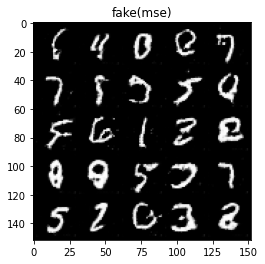

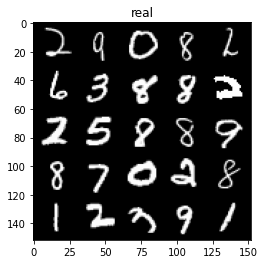

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss(BCE): 0.7013062945604324, Discriminator loss(BCE): 0.6973030010461805
Step 17000: Generator loss(MSE): 0.2565977052152156, Discriminator loss(MSE): 0.2513392641246319


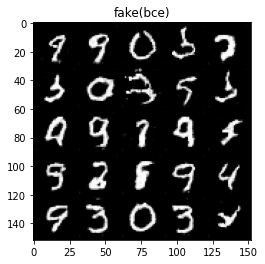

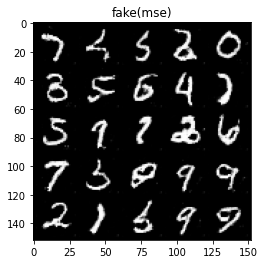

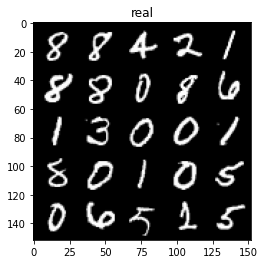

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss(BCE): 0.7010071961879732, Discriminator loss(BCE): 0.6971662261486054
Step 17500: Generator loss(MSE): 0.2572468684017659, Discriminator loss(MSE): 0.25124508959054964


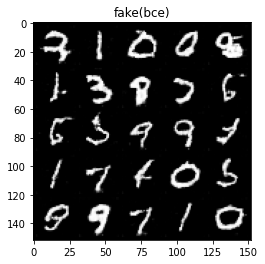

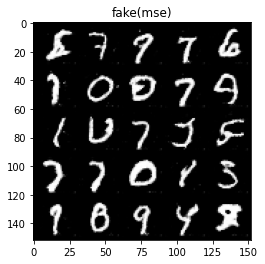

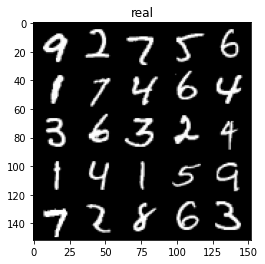

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss(BCE): 0.7011770431995392, Discriminator loss(BCE): 0.6970396317243576
Step 18000: Generator loss(MSE): 0.2566118006706239, Discriminator loss(MSE): 0.25122624653577796


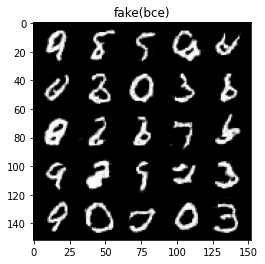

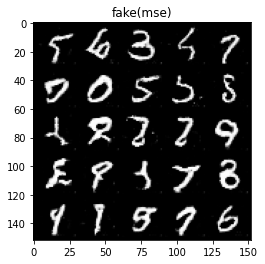

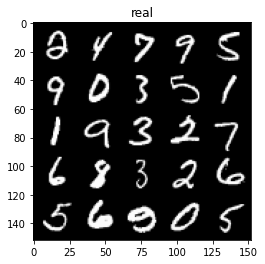

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss(BCE): 0.7003988571166995, Discriminator loss(BCE): 0.696710975766182
Step 18500: Generator loss(MSE): 0.2557945106774569, Discriminator loss(MSE): 0.25148214769363414


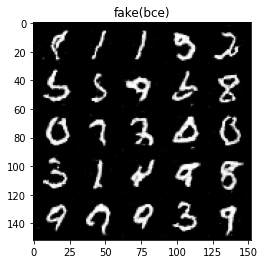

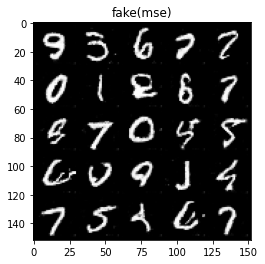

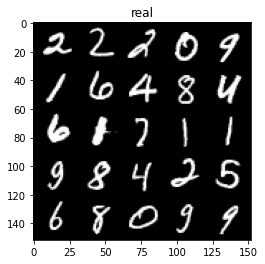

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss(BCE): 0.7001038271188733, Discriminator loss(BCE): 0.6967058533430097
Step 19000: Generator loss(MSE): 0.2564318886697292, Discriminator loss(MSE): 0.25166981697082513


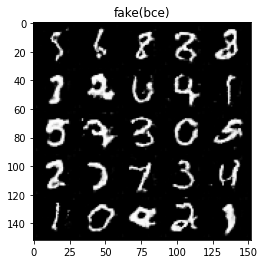

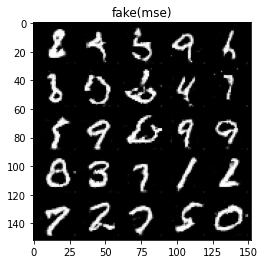

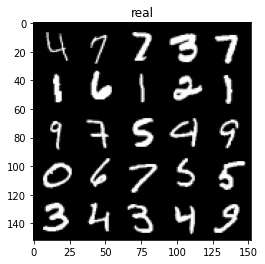

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss(BCE): 0.6987796920537951, Discriminator loss(BCE): 0.696550020337105
Step 19500: Generator loss(MSE): 0.2557262432575229, Discriminator loss(MSE): 0.2508850007653235


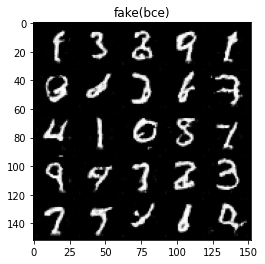

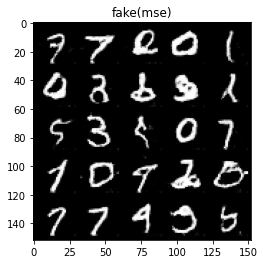

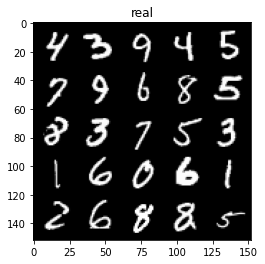

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss(BCE): 0.6981501605510716, Discriminator loss(BCE): 0.6964123251438145
Step 20000: Generator loss(MSE): 0.25503130994737144, Discriminator loss(MSE): 0.2515464224219321


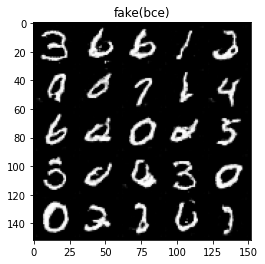

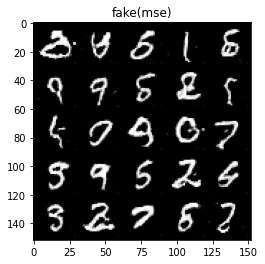

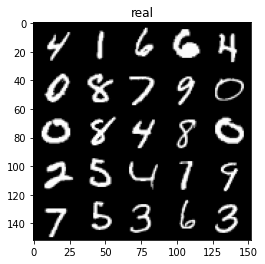

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss(BCE): 0.6993999764919276, Discriminator loss(BCE): 0.6963373193740846
Step 20500: Generator loss(MSE): 0.25499103358387953, Discriminator loss(MSE): 0.25117941427230833


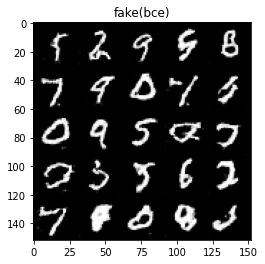

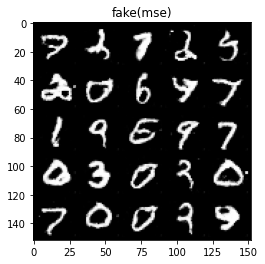

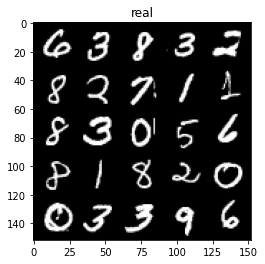

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss(BCE): 0.6987654681205753, Discriminator loss(BCE): 0.6960900228023528
Step 21000: Generator loss(MSE): 0.25476716783642783, Discriminator loss(MSE): 0.2510352712869642


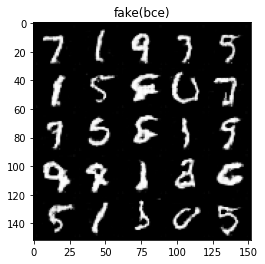

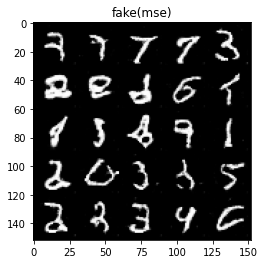

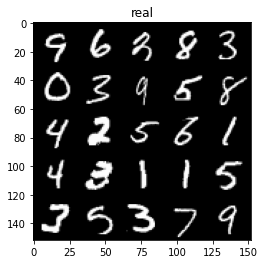

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss(BCE): 0.6979873886108404, Discriminator loss(BCE): 0.696217798948287
Step 21500: Generator loss(MSE): 0.25538758245110516, Discriminator loss(MSE): 0.2510258143544197


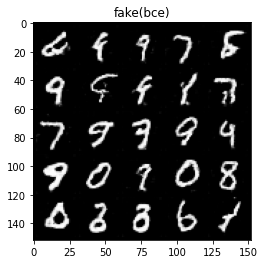

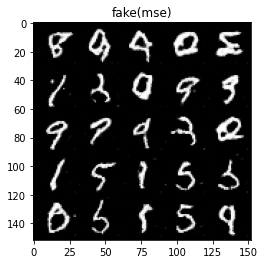

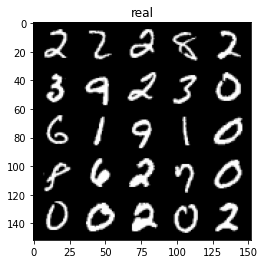

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss(BCE): 0.6969813637733455, Discriminator loss(BCE): 0.696106436967849
Step 22000: Generator loss(MSE): 0.2555670767426493, Discriminator loss(MSE): 0.2509737388789651


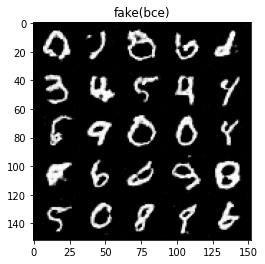

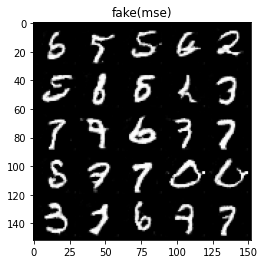

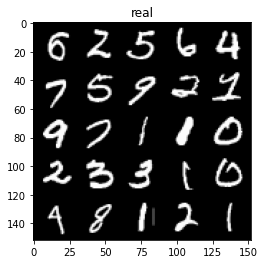

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss(BCE): 0.6974285399913797, Discriminator loss(BCE): 0.6960309338569641
Step 22500: Generator loss(MSE): 0.25493362697958943, Discriminator loss(MSE): 0.25121700489521026


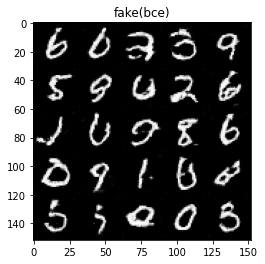

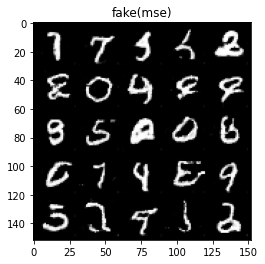

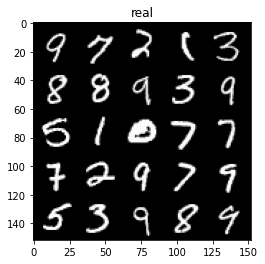

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss(BCE): 0.6978125562667847, Discriminator loss(BCE): 0.6956471201181412
Step 23000: Generator loss(MSE): 0.2528712235391138, Discriminator loss(MSE): 0.25153653115034114


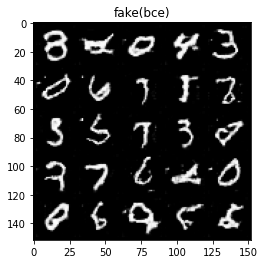

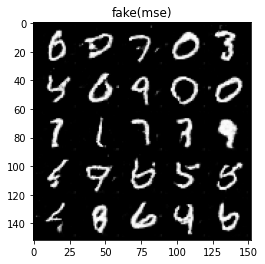

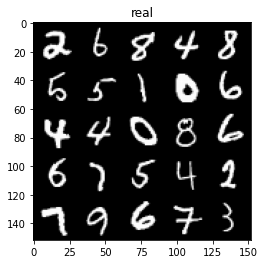

In [11]:
Generator_losses_bce = []
Discriminator_losses_bce = []
Generator_losses_mse = []
Discriminator_losses_mse = []


# Training Process Cell
n_epochs = 50
cur_step = 0
mean_generator_loss_with_bce = 0
mean_discriminator_loss_with_bce = 0

mean_generator_loss_with_mse = 0
mean_discriminator_loss_with_mse = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt_with_bce.zero_grad()
        disc_opt_with_mse.zero_grad()

        # noise 벡터 생성
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        # noise vector를 입력받아 BCE Loss를 이용하는 Generator를 통하여 fake 이미지를 생성
        fake_with_bce = gen_with_bce(fake_noise)
        # noise vector를 입력받아 MSE Loss를 이용하는 Generator를 통하여 fake 이미지를 생성
        fake_with_mse = gen_with_mse(fake_noise)

        # BCE Loss를 이용하는 Discriminator를 통하여 fake 이미지의 진위를 판별
        disc_fake_pred_with_bce = disc_with_bce(fake_with_bce.detach())
        # MSE Loss를 이용하는 Discriminator를 통하여 fake 이미지의 진위를 판별
        disc_fake_pred_with_mse = disc_with_mse(fake_with_mse.detach())

        # BCE Loss를 이용하는 Discriminator를 통하여 fake 이미지의 Binary Cross Entropy Loss를 계산
        disc_fake_loss_with_bce = bce_loss(disc_fake_pred_with_bce, torch.zeros_like(disc_fake_pred_with_bce))
        # MSE Loss를 이용하는 Discriminator를 통하여 fake 이미지의 Mean Squared Error Loss를 계산
        disc_fake_loss_with_mse = mse_loss(disc_fake_pred_with_mse, torch.zeros_like(disc_fake_pred_with_mse))

        # BCE Loss를 이용하는 Discriminator를 통하여 real 이미지의 진위를 판별
        disc_real_pred_with_bce = disc_with_bce(real)
        # MSE Loss를 이용하는 Discriminator를 통하여 real 이미지의 진위를 판별
        disc_real_pred_with_mse = disc_with_mse(real)

        # BCE Loss를 이용하는 Discriminator를 통하여 real 이미지의 Binary Cross Entropy Loss를 계산
        disc_real_loss_with_bce = bce_loss(disc_real_pred_with_bce, torch.ones_like(disc_real_pred_with_bce))
        # 가짜 이미지와 진짜 이미지 모두에서 구한 Binary Cross Entropy Loss들을 합산
        disc_loss_with_bce = (disc_fake_loss_with_bce + disc_real_loss_with_bce) / 2

        # MSE Loss를 이용하는 Discriminator를 통하여 real 이미지의 Mean Squared Error Loss를 계산
        disc_real_loss_with_mse = mse_loss(disc_real_pred_with_mse, torch.ones_like(disc_real_pred_with_mse))
        # 가짜 이미지와 진짜 이미지 모두에서 구한 Mean Squared Error Loss들을 합산
        disc_loss_with_mse = (disc_fake_loss_with_mse + disc_real_loss_with_mse) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss_with_bce += disc_loss_with_bce.item() / display_step
        mean_discriminator_loss_with_mse += disc_loss_with_mse.item() / display_step

        # Update gradients
        # BCE Loss를 이용하는 Discriminator의 변화도를 계산
        disc_loss_with_bce.backward(retain_graph=True)
        # MSE Loss를 이용하는 Discriminator의 변화도를 계산
        disc_loss_with_mse.backward(retain_graph=True)

        # Update optimizer
        # 역전파를 통하여 BCE Loss를 이용하는 Discriminator를 업데이트
        disc_opt_with_bce.step()
        # 역전파를 통하여 MSE Loss를 이용하는 Discriminator를 업데이트
        disc_opt_with_mse.step()

        ## Update generator ##
        gen_opt_with_bce.zero_grad()
        gen_opt_with_mse.zero_grad()

        # noise 벡터 생성
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)

        # noise vector를 입력받아 BCE Loss를 이용하는 Generator를 통하여 fake 이미지를 생성
        fake_2_with_bce = gen_with_bce(fake_noise_2)
        # noise vector를 입력받아 MSE Loss를 이용하는 Generator를 통하여 fake 이미지를 생성
        fake_2_with_mse = gen_with_mse(fake_noise_2)

        # BCE Loss를 이용하는 업데이트 된 Discriminator를 통하여 fake 이미지의 진위를 판별
        disc_fake_pred_with_bce = disc_with_bce(fake_2_with_bce)
        # MSE Loss를 이용하는 업데이트 된 Discriminator를 통하여 fake 이미지의 진위를 판별
        disc_fake_pred_with_mse = disc_with_mse(fake_2_with_mse)

        # BCE Loss를 이용하는 Generator를 통하여 fake 이미지의 Binary Cross Entropy Loss를 계산
        gen_loss_with_bce = bce_loss(disc_fake_pred_with_bce, torch.ones_like(disc_fake_pred_with_bce))
        # 역전파를 통해 BCE Loss를 이용하는 Generator의 변화도 계산
        gen_loss_with_bce.backward()
        # 역전파를 통해 BCE Loss를 이용하는 Generator를 업데이트
        gen_opt_with_bce.step()

        # MSE Loss를 이용하는 Generator를 통하여 fake 이미지의 Mean Squared Error Los를 계산
        gen_loss_with_mse = mse_loss(disc_fake_pred_with_mse, torch.ones_like(disc_fake_pred_with_mse))
        # 역전파를 통해 MSE Loss를 이용하는 Generator의 변화도 계산
        gen_loss_with_mse.backward()
        # 역전파를 통해 MSE Loss를 이용하는 Generator를 업데이트
        gen_opt_with_mse.step()

        # BCE Loss List에 추가
        Generator_losses_bce.append(gen_loss_with_bce.item())
        Discriminator_losses_bce.append(disc_loss_with_bce.item())
        
        # MSE Loss List에 추가
        Generator_losses_mse.append(gen_loss_with_mse.item()) 
        Discriminator_losses_mse.append(disc_loss_with_mse.item())

        # Keep track of the average generator loss
        mean_generator_loss_with_bce += gen_loss_with_bce.item() / display_step
        mean_generator_loss_with_mse += gen_loss_with_mse.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss(BCE): {mean_generator_loss_with_bce}, Discriminator loss(BCE): {mean_discriminator_loss_with_bce}")
            print(f"Step {cur_step}: Generator loss(MSE): {mean_generator_loss_with_mse}, Discriminator loss(MSE): {mean_discriminator_loss_with_mse}")
            show_tensor_images(fake_with_bce, 'fake(bce)')
            show_tensor_images(fake_with_mse, 'fake(mse)')
            show_tensor_images(real, 'real')


            mean_generator_loss_with_bce = 0
            mean_generator_loss_with_mse = 0
            mean_discriminator_loss_with_bce = 0
            mean_discriminator_loss_with_mse = 0
            
        cur_step += 1


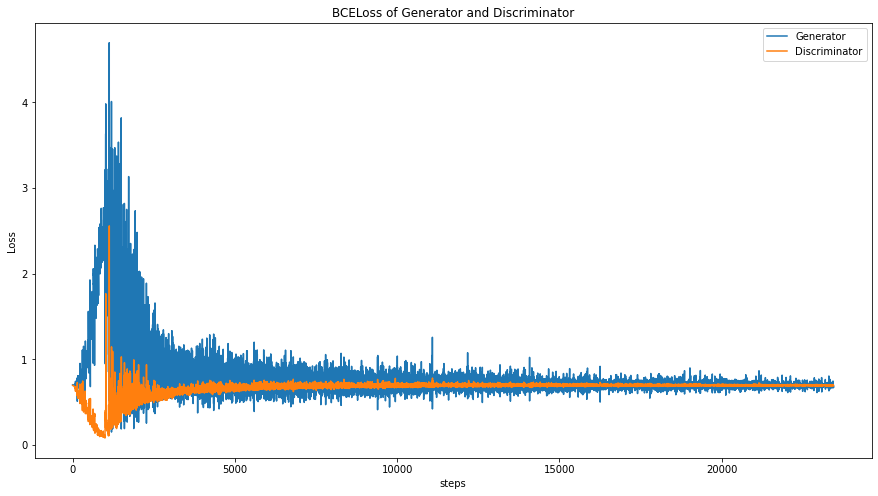

In [12]:
plt.figure(figsize=(15,8))
plt.title("BCELoss of Generator and Discriminator")
plt.plot(Generator_losses_bce,label="Generator")
plt.plot(Discriminator_losses_bce,label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

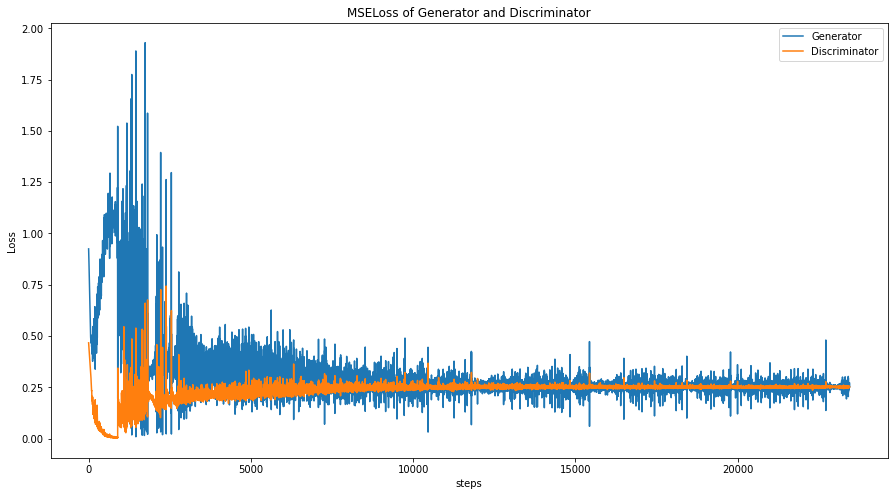

In [13]:
plt.figure(figsize=(15,8))
plt.title("MSELoss of Generator and Discriminator")
plt.plot(Generator_losses_mse,label="Generator")
plt.plot(Discriminator_losses_mse,label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

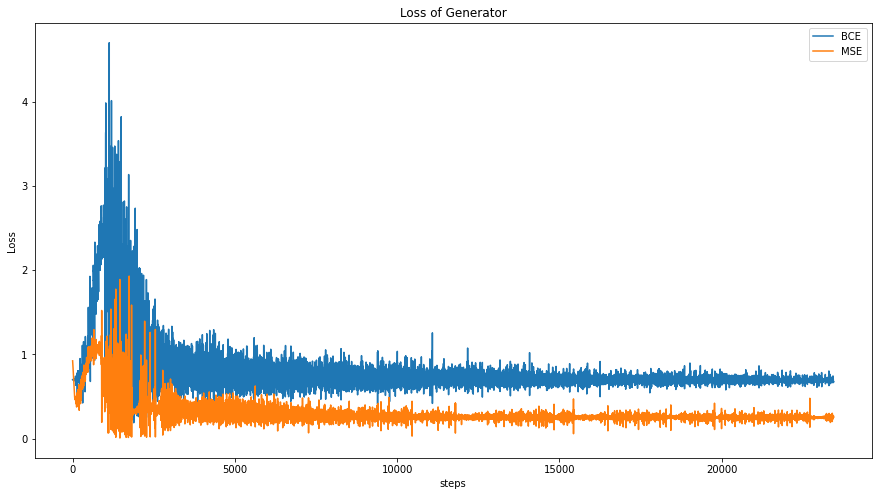

In [14]:
plt.figure(figsize=(15,8))
plt.title("Loss of Generator")
plt.plot(Generator_losses_bce,label="BCE")
plt.plot(Generator_losses_mse,label="MSE")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

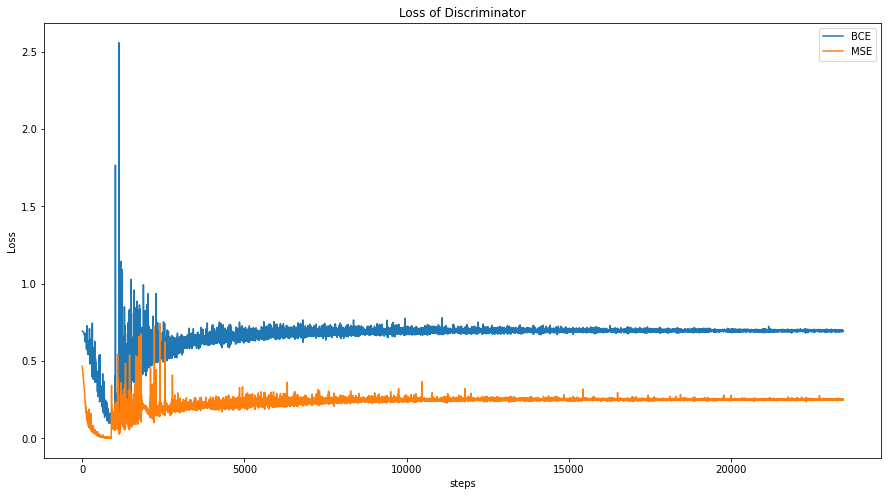

In [15]:
plt.figure(figsize=(15,8))
plt.title("Loss of Discriminator")
plt.plot(Discriminator_losses_bce,label="BCE")
plt.plot(Discriminator_losses_mse,label="MSE")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()